In [1]:
import clickhouse_connect
from dotenv import load_dotenv
from google.cloud import bigquery
import json
import matplotlib.pyplot as plt
import pandas as pd
import os

from scripts.charts import distributions_barchart

In [2]:
load_dotenv()

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '../../../oso_gcp_credentials.json'
GCP_PROJECT = 'opensource-observer'
#bq_client = bigquery.Client(GCP_PROJECT)

CLICKHOUSE_HOST = os.environ['CLICKHOUSE_HOST']
CLICKHOUSE_USER = os.environ['CLICKHOUSE_USER']
CLICKHOUSE_PASS = os.environ['CLICKHOUSE_PASSWORD']
# ch_client = clickhouse_connect.get_client(
#     host=CLICKHOUSE_HOST,
#     user=CLICKHOUSE_USER,
#     password=CLICKHOUSE_PASS,
#     secure=True
# )

In [3]:
df_funding = pd.read_csv('../../../../oss-funding/data/funding_data.csv')

df_funding = df_funding[df_funding['from_funder_name'] == 'optimism']
df_funding = df_funding[df_funding['grant_pool_name'].str.contains('retro')==True]

df_funding['metadata'] = df_funding['metadata'].apply(json.loads)
df_funding['application_name'] = df_funding['metadata'].apply(lambda x: x.get('application_name'))
df_funding['round'] = df_funding['grant_pool_name'].apply(lambda x: int(x[-1]))

df_funding['tokens'] = df_funding['metadata'].apply(lambda x: pd.to_numeric(x['token_amount']))
df_funding = df_funding[df_funding['tokens'] > 0]

df_funding.rename(columns={'to_project_name': 'project_name'}, inplace=True)
cols = ['application_name', 'project_name', 'round', 'tokens', 'amount']
df_funding = df_funding[cols]

df_funding.tail(1)

,application_name,project_name,round,tokens,amount
1443,Solady,solady-vectorized,5,95072.810791,161623.778345


In [4]:
df_funding.groupby('round')['amount'].sum() / 1_000_000

round
2     15.000011
3    104.999999
4     18.000000
5     13.600000
Name: amount, dtype: float64

In [5]:
cols = [
    'name', 'organization', 'round', 'category', 'profileAvatarUrl',
    'github', 'contracts', 'grantsAndFunding'
]
def load_project_json(round_num):
    with open(f'data/_local/rf{round_num}_projects.json', 'r') as f:        
        rf_data = json.load(f)
        df_rf = pd.DataFrame(rf_data).set_index('applicationId')
        df_rf['round'] = round_num
        if round_num == 4:
            df_rf['category'] = df_rf['category'].str.upper()
            df_rf['organization'] = df_rf['name']
        else:
            df_rf['category'] = df_rf['applicationCategory']
            df_rf['organization'] = df_rf.apply(
                lambda x: x['organization'].get('name') if isinstance(x['organization'], dict) else x['name'],
                axis=1
            )
        return df_rf[cols]
    
def extract_funding(x, funding_type):
    if isinstance(x, dict):
        f = x.get(funding_type, [])
        if len(f) > 0:
            return True
        else:
            if funding_type == 'retroFunding':
                grants = x.get('grants', [])
                if len(grants):
                    for g in grants:
                        if g['grant'] == 'retroFunding':
                            return True
    return False

def get_grant_amounts(x):
    funding = 0
    if isinstance(x, dict):
        grants = x.get('grants', [])
        if len(grants):
            for g in grants:
                if g['grant'] == 'retroFunding':
                    continue
                try:
                    funding += pd.to_numeric(g['amount'])
                except:
                    continue
    return funding

def get_githubs(x):
    githubs = []
    if not isinstance(x, list):
        return githubs
    for item in x:
        if isinstance(item, str):
            githubs.append(item.lower())
        else:
            g = item.get('url')
            githubs.append(g.lower())
    return githubs    

In [6]:
rounds = [4,5,6]
df = pd.concat([load_project_json(r) for r in rounds], axis=0, ignore_index=True)    

df['partOfOrganization'] = (df['organization'] == df['name'])   
df['hasVentureFunding'] = df['grantsAndFunding'].apply(lambda x: extract_funding(x, 'ventureFunding'))
df['hasRevenue'] = df['grantsAndFunding'].apply(lambda x: extract_funding(x, 'revenue'))
df['hasRetroFunding'] = df['grantsAndFunding'].apply(lambda x: extract_funding(x, 'retroFunding'))
df['grantAmounts'] = df['grantsAndFunding'].apply(get_grant_amounts)
df['hasGrants'] = df['grantAmounts'] > 0
df['github'] = df['github'].apply(get_githubs)

df.tail(1)

,name,organization,round,category,profileAvatarUrl,github,contracts,grantsAndFunding,partOfOrganization,hasVentureFunding,hasRevenue,hasRetroFunding,grantAmounts,hasGrants
390,Optimism Grant analytics: Grant3,OP Grants Tracker,6,GOVERNANCE_ANALYTICS,https://storage.googleapis.com/op-atlas/2094ae...,[],[],"{'ventureFunding': [], 'grants': [], 'revenue'...",False,False,False,True,0.0,False


In [7]:
# https://docs.google.com/spreadsheets/d/1Ul8iMTsOFUKUmqz6MK0zpgt8Ki8tFtoWKGlwXj-Op34/edit?gid=769451685#gid=769451685
print("Total prospective grants:")
print(
    df.drop_duplicates(subset=['organization', 'hasGrants'])
    ['hasGrants'].value_counts()
)

print(
    df.drop_duplicates(subset=['organization', 'grantAmounts'])
    .sort_values(by='grantAmounts')
    ['grantAmounts'].sum()
)

Total prospective grants:
hasGrants
False    262
True      90
Name: count, dtype: int64
34468206.31


In [8]:
print("Projects with revenue:")
print(
    df.drop_duplicates(subset=['organization', 'hasRevenue'])
    ['hasRevenue'].value_counts()
)
print()
print(
    df.set_index(['name', 'round'])[['hasRevenue']]
    .join(
        df_funding
        .rename(columns={'application_name': 'name'})
        .set_index(['name', 'round'])[['tokens']]
    )
    .dropna()
    .groupby('hasRevenue')['tokens'].median()
)

Projects with revenue:
hasRevenue
False    191
True     160
Name: count, dtype: int64

hasRevenue
False    72457.463023
True     15480.462474
Name: tokens, dtype: float64


In [9]:
print("Venture capital analysis:")
print()
print(
    df[['organization', 'hasVentureFunding']]
    .drop_duplicates()
    ['hasVentureFunding'].value_counts()
)
print()
print(
    df.set_index(['name', 'round'])[['hasVentureFunding']]
    .join(
        df_funding
        .rename(columns={'application_name': 'name'})
        .set_index(['name', 'round'])[['tokens']]
    )
    .dropna()
    .groupby('hasVentureFunding')['tokens'].median()
)

Venture capital analysis:

hasVentureFunding
False    286
True      64
Name: count, dtype: int64

hasVentureFunding
False    47046.339630
True     23349.664401
Name: tokens, dtype: float64


In [10]:
df_funding['label'] = df_funding.apply(
    lambda x: x['project_name'] if not pd.isna(x['project_name']) else x['application_name'],
    axis=1)

print(
    df_funding['label'].nunique(),
    df_funding['tokens'].sum()
)

771 58000006.64


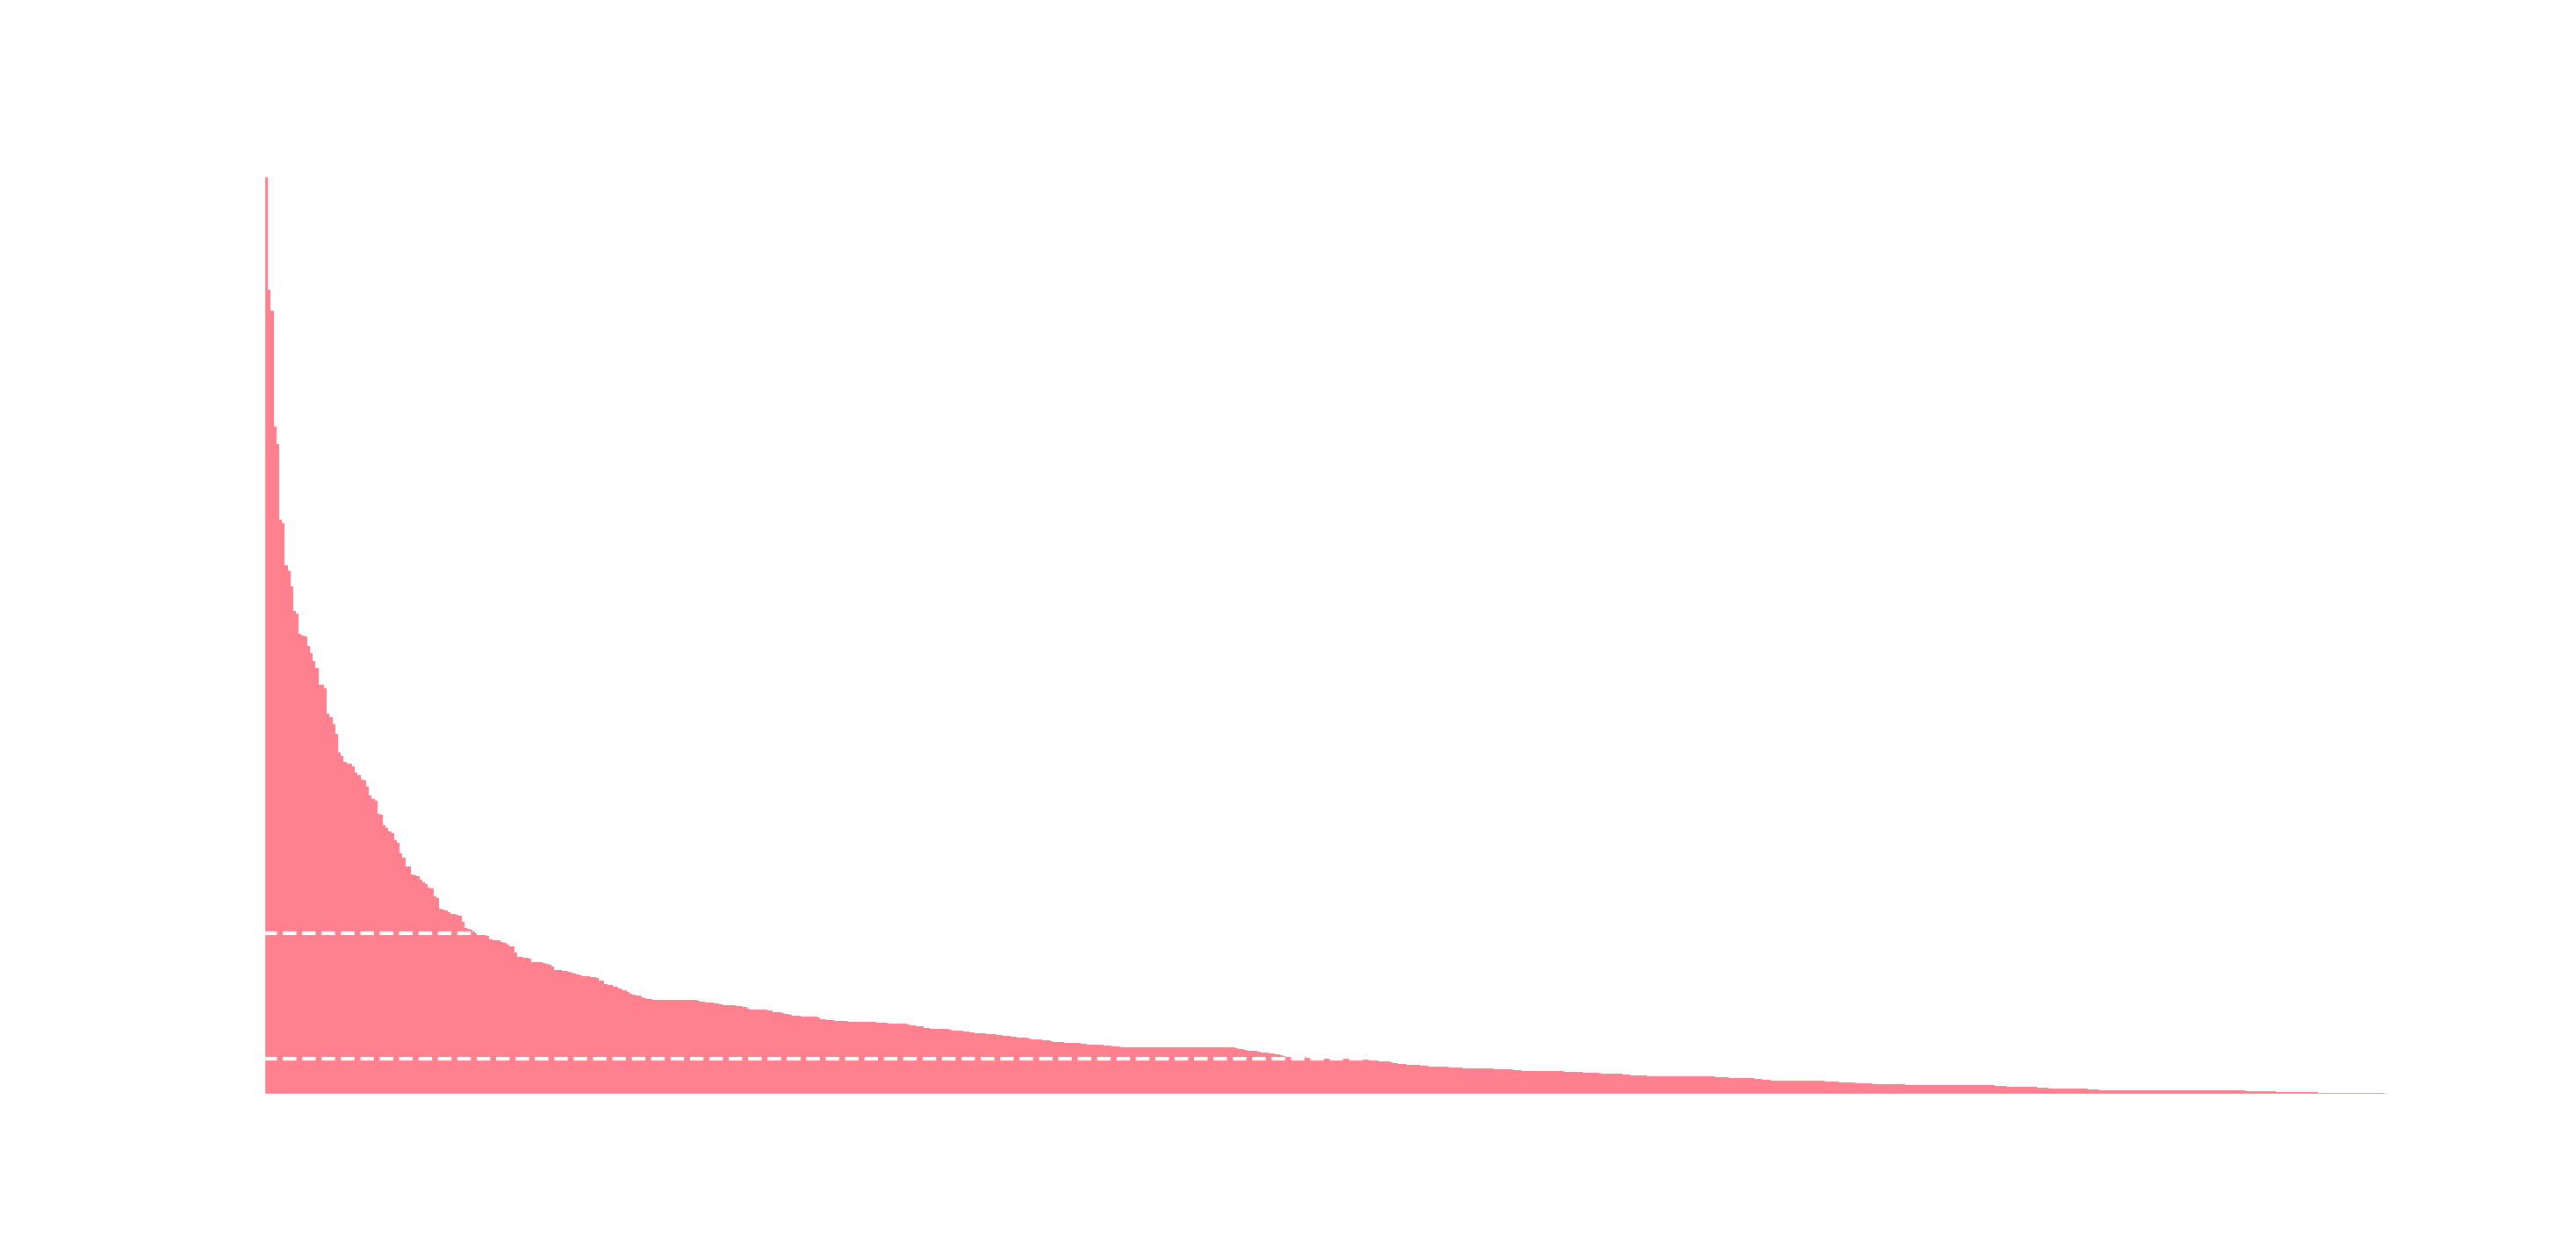

In [11]:
distros = df_funding.groupby('label')['tokens'].sum().sort_values(ascending=False)

f = distributions_barchart(
    distros,
    title="Cumulative Retro Funding distributions to projects (Rounds 2-5)",
    ymax=1000,
    ystep=200,
    xstep=100
)

f.set_facecolor('none')

Text(0, 0.5, 'Funding (OP)')

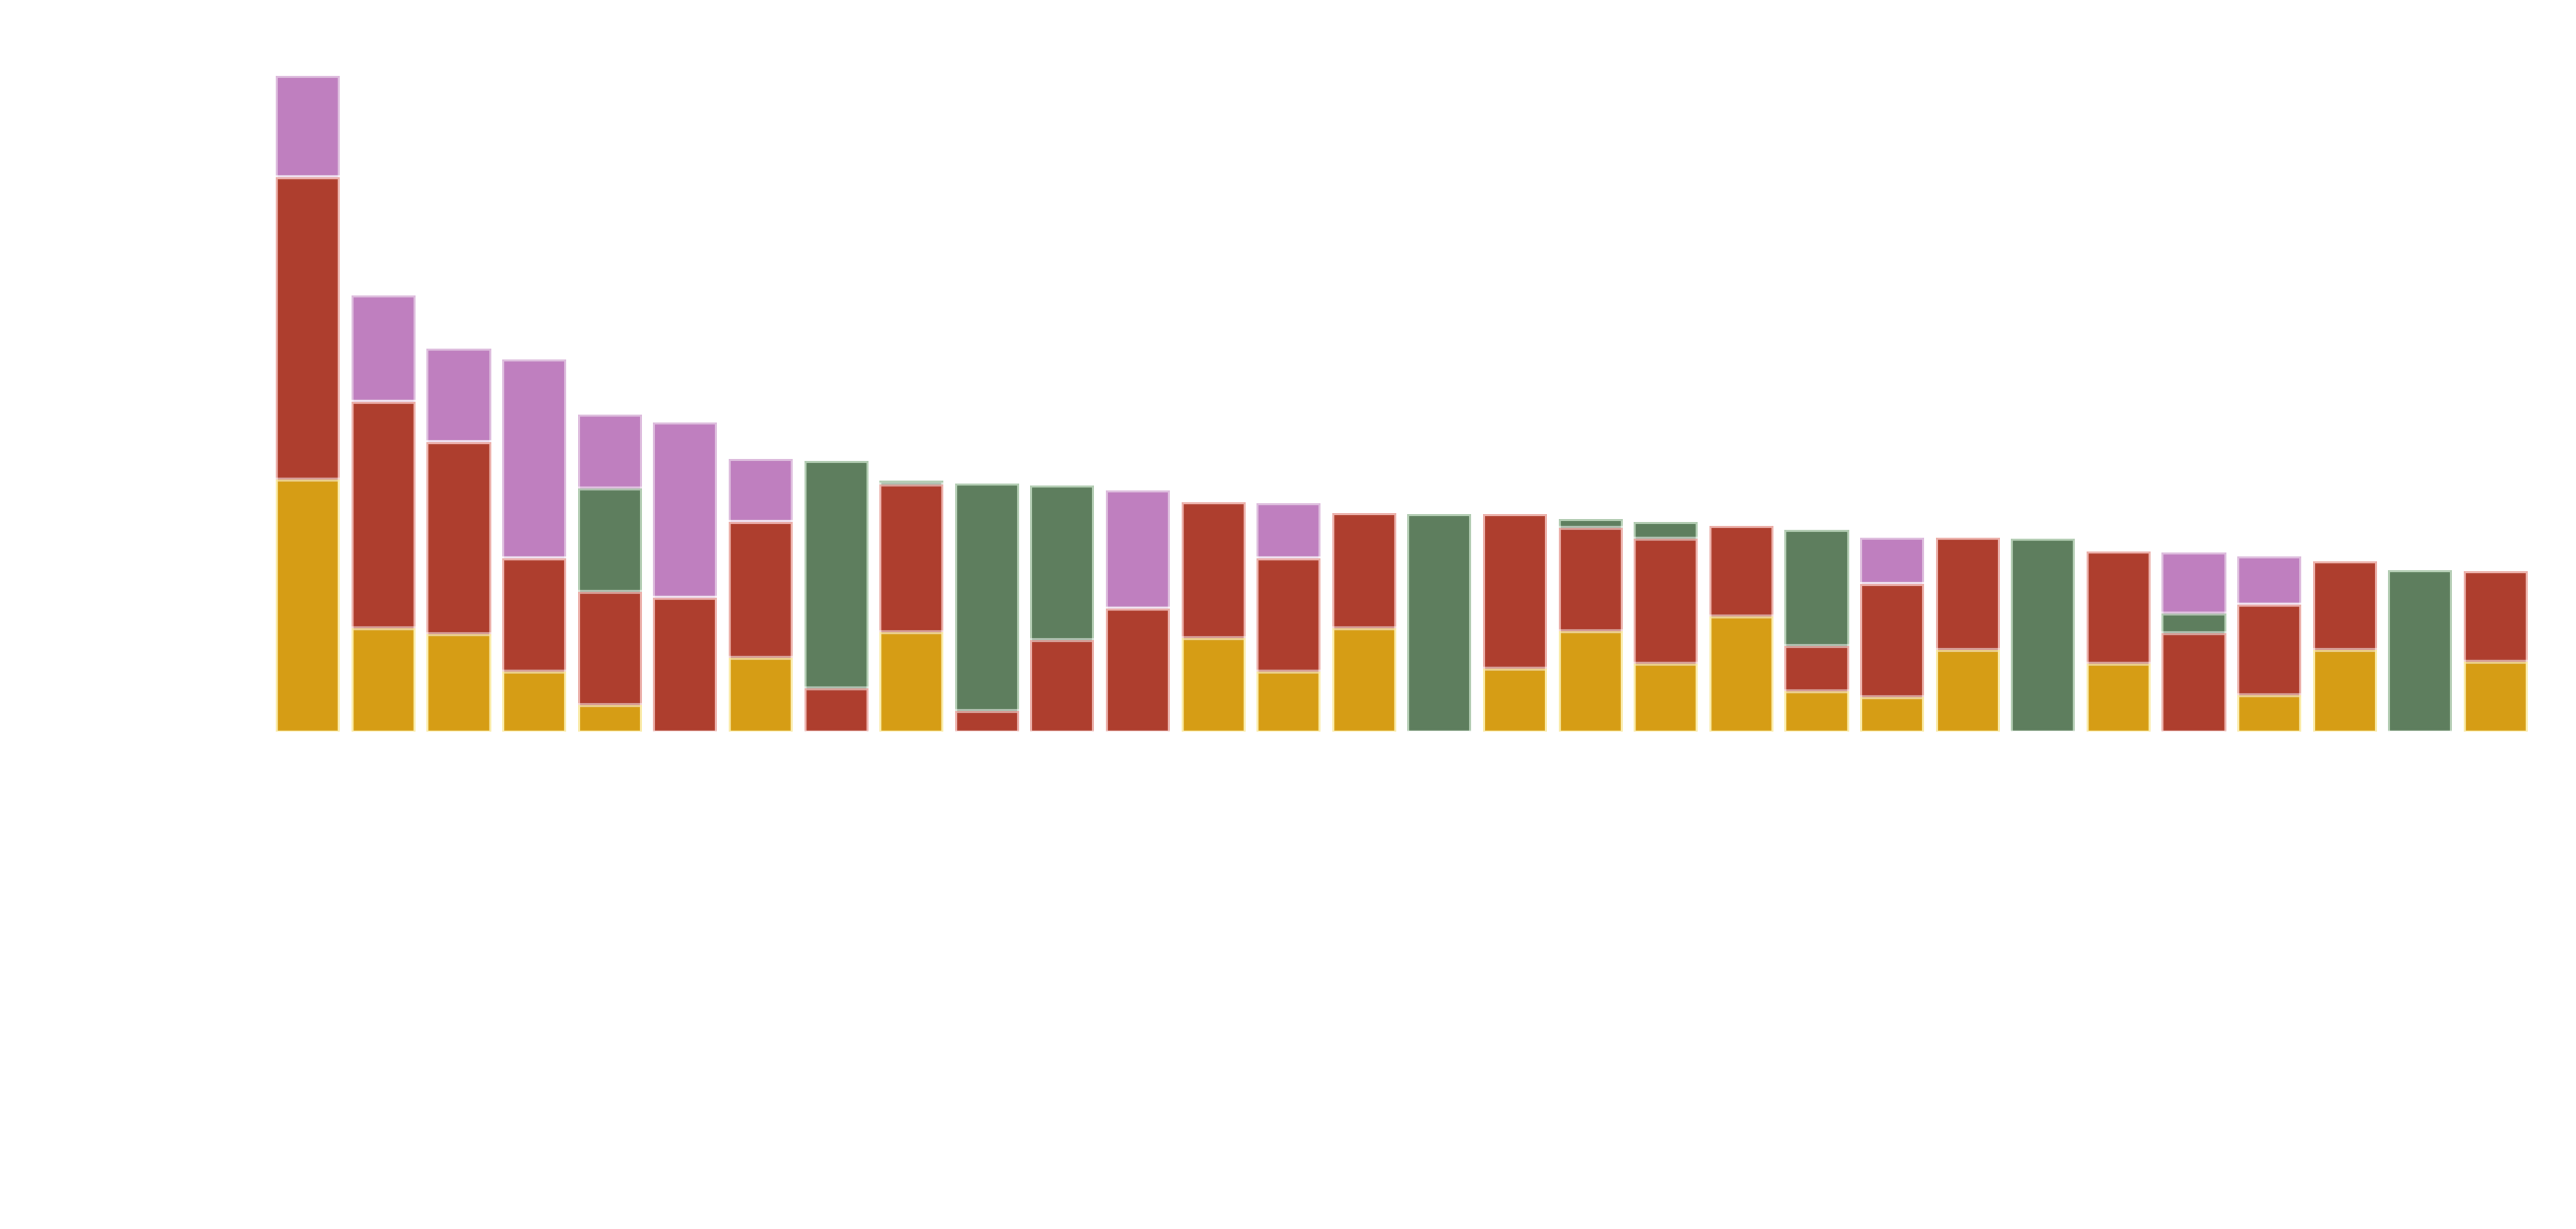

In [12]:
from scripts.charts import get_plot, format_axis

top_projects = list(distros[distros > 350_000].index)
top_projects.extend(['aerodrome-finance','velodrome'])

df_top_project_names = pd.read_csv('data/_local/project_names.csv', index_col=[0,1])
df_top = (
    df_funding[
        df_funding.project_name.isin(top_projects)
    ]
    .set_index(['project_name', 'application_name'])
    .join(df_top_project_names)
    .drop_duplicates()
    .reset_index()
)
df_top['tokens'] = df_top['tokens'] / 1_000_000
project_order = df_top.groupby('project_label')['tokens'].sum().sort_values(ascending=False)

fig, ax = get_plot(
    project_order,
    kind='bar',
    color='white',
    alpha=.5,
    edgecolor='white',
    width=.85
)

colors = {5: 'purple', 4: 'green', 3: 'red', 2: 'yellow'}
for r in sorted(df_top['round'].unique(), reverse=True):
    for i,p in enumerate(project_order.index):
        f = df_top[(df_top['project_label'] == p) & (df_top['round'] <= r)]['tokens'].sum()
        ax.bar(x=i, height=f, color=colors.get(r), alpha=.5, edgecolor='white', width=.85)

ax.set_xlabel("")
format_axis(ax, ypost='M', yfmt=".1f", ystep=.25, ymax=1.5)
ax.set_ylabel('Funding (OP)')

In [13]:
repo_urls = []
for glist in df['github']:
    repo_urls.extend(glist)
repo_urls = list(set(repo_urls))

repo_urls_str = "'" + "','".join(repo_urls) + "'"
repos_query = f"""
    select
      abp.artifact_id,
      abp.artifact_namespace,
      abp.artifact_name,
      abp.artifact_url,
      abp.artifact_type,
      rm.is_fork,
      rm.fork_count,
      rm.star_count,
      rm.language,
      rm.license_spdx_id,
      abp.project_id as oso_project_id,
    from `oso.int_artifacts_in_ossd_by_project` as abp
    join `oso.int_repo_metrics_by_project` as rm
      on abp.artifact_id = rm.artifact_id
    where abp.artifact_url in ({repo_urls_str})
"""


# repos_query_result = client.query(repos_query)
# df_repos = repos_query_result.to_dataframe()
# df_repos.to_parquet('data/_local/repo_metrics.parquet')

df_repos = pd.read_parquet('data/_local/repo_metrics.parquet')

df_repos.tail(1)

,artifact_id,artifact_namespace,artifact_name,artifact_url,artifact_type,is_fork,fork_count,star_count,language,license_spdx_id,oso_project_id
587,EfQGtZdYoGnJfiBDCPu_UMv8mqjIZ9FWfTcUEpUz-EY=,ethereum-optimism,asterisc,https://github.com/ethereum-optimism/asterisc,REPOSITORY,False,15,99,Go,MIT,89Tit1JWeJvJFw5pp7BjqTlEOvLXRQIw7tgZUI1_pj4=


In [14]:
oso_project_id_str = "'" + "','".join(df_repos['oso_project_id'].unique()) + "'"

# results = client.query(f"""
#     select
#         project_id,
#         sample_date,
#         amount,
#         metric_name
#     from timeseries_metrics_by_project_v0 as t
#     join metrics_v0 as m on t.metric_id = m.metric_id
#     where
#         project_id in ({oso_project_id_str})
#         and metric_name in ('full_time_developers_over_30_day', 'active_developers_over_30_day')
# """)
# df_timeseries = pd.DataFrame(results.result_set, columns=results.column_names)
# df_timeseries.to_parquet('data/_local/timeseries_metrics_by_project.parquet')
df_timeseries = pd.read_parquet('data/_local/timeseries_metrics_by_project.parquet')
df_timeseries.tail(1)

,project_id,sample_date,amount,metric_name
314515,zuKa56R3a-6e4jZZUfd7UOWS66f0hkwUMt8uFboQArk=,2024-10-22,3.0,active_developers_over_30_day


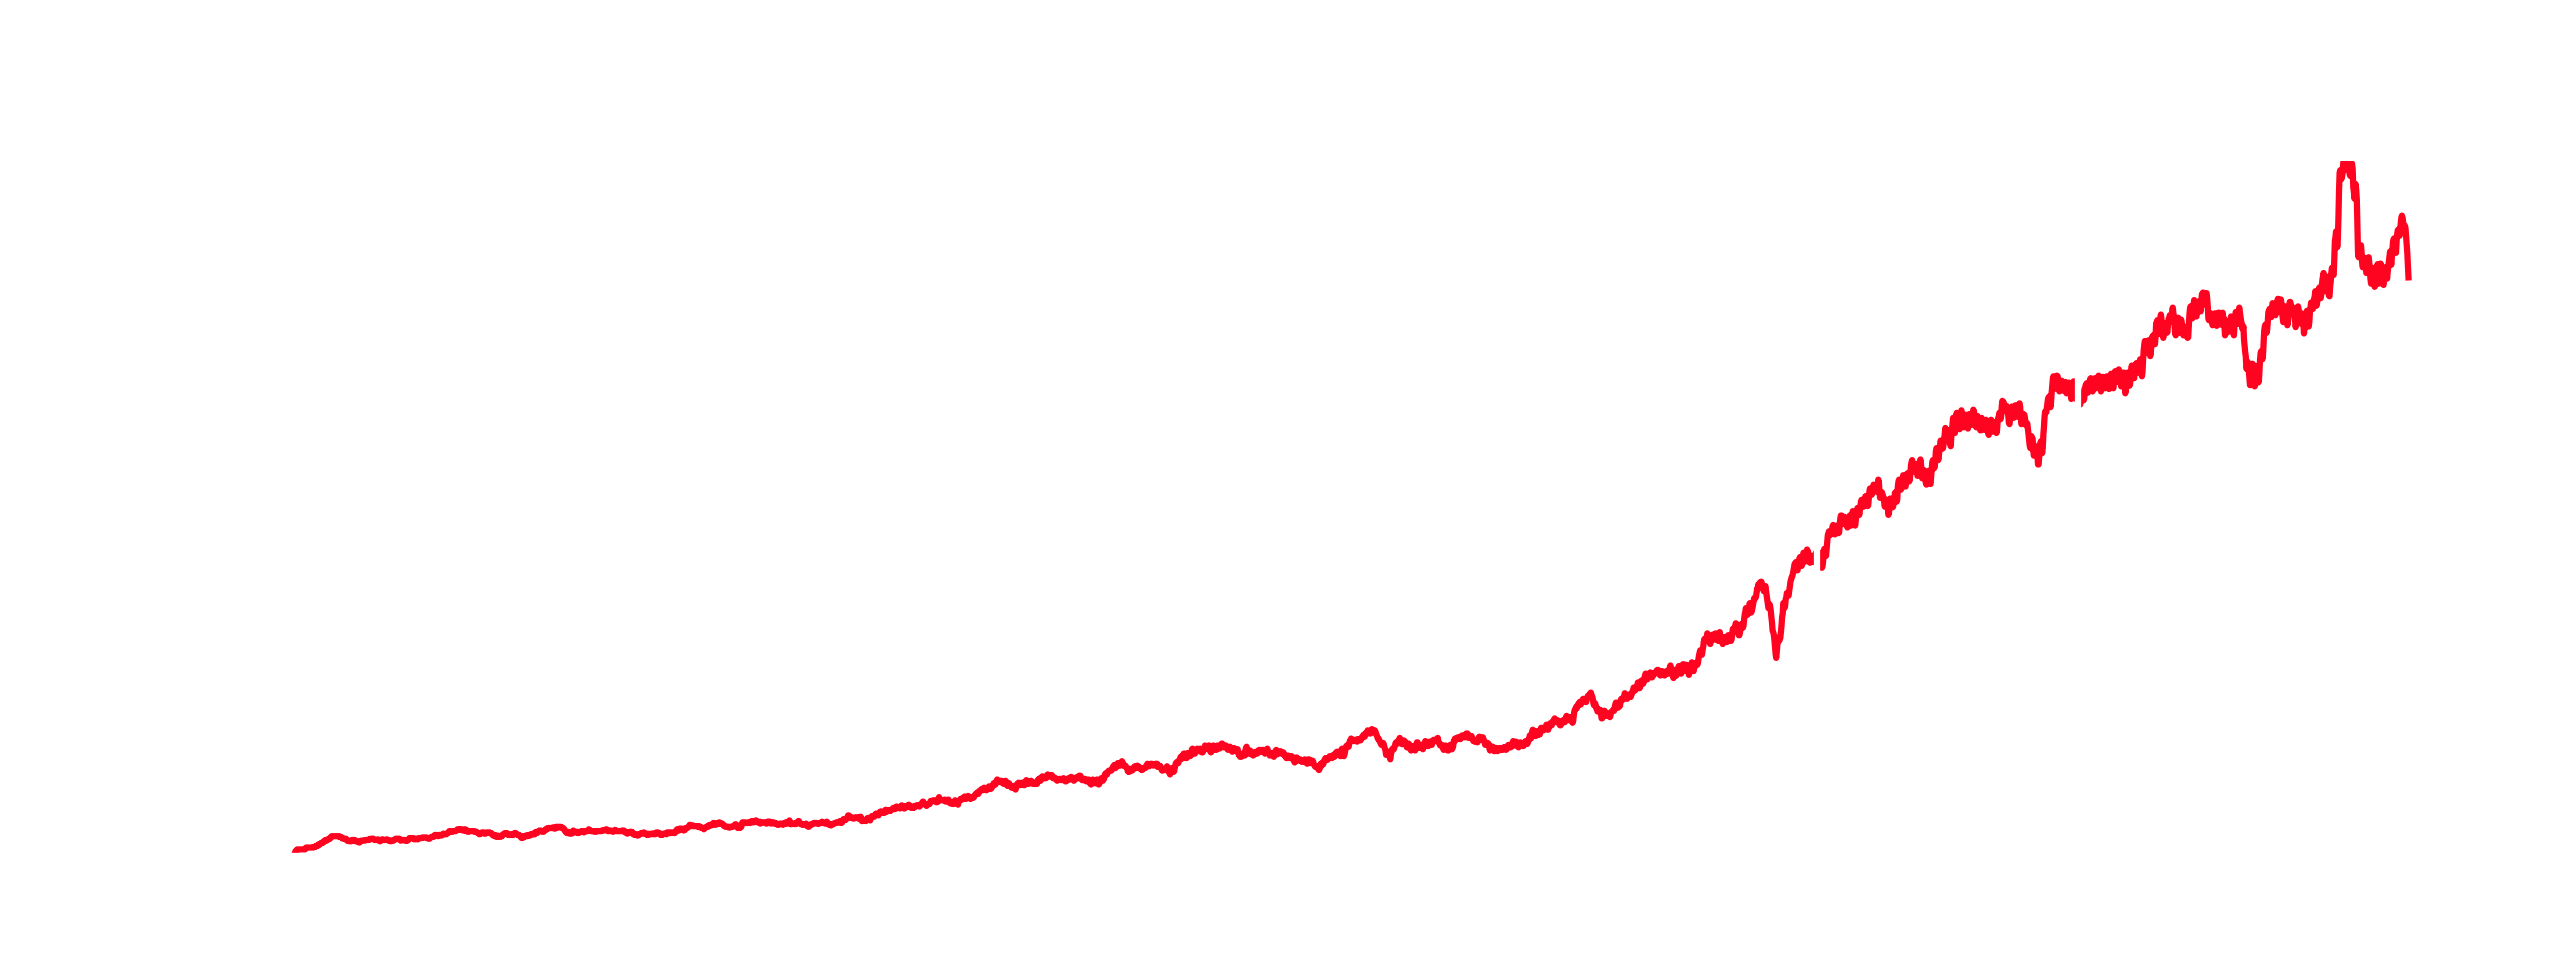

In [15]:
active_devs = (
    df_timeseries[
        (df_timeseries['metric_name'] == 'active_developers_over_30_day')
        & (pd.to_datetime(df_timeseries['sample_date']) < pd.to_datetime('2024-10-01'))
    ]
    .groupby('sample_date')['amount']
    .sum()
)
fig, ax = get_plot(active_devs, kind='line', color='#ff0420')
format_axis(ax, ymax=1100)
ax.set_xlabel("")
ax.set_title("Monthly active developers, 30-day rolling average\n", loc='left', weight='bold')
ax.axvline(19000, color='white')
ax.axvline(19440, color='white')

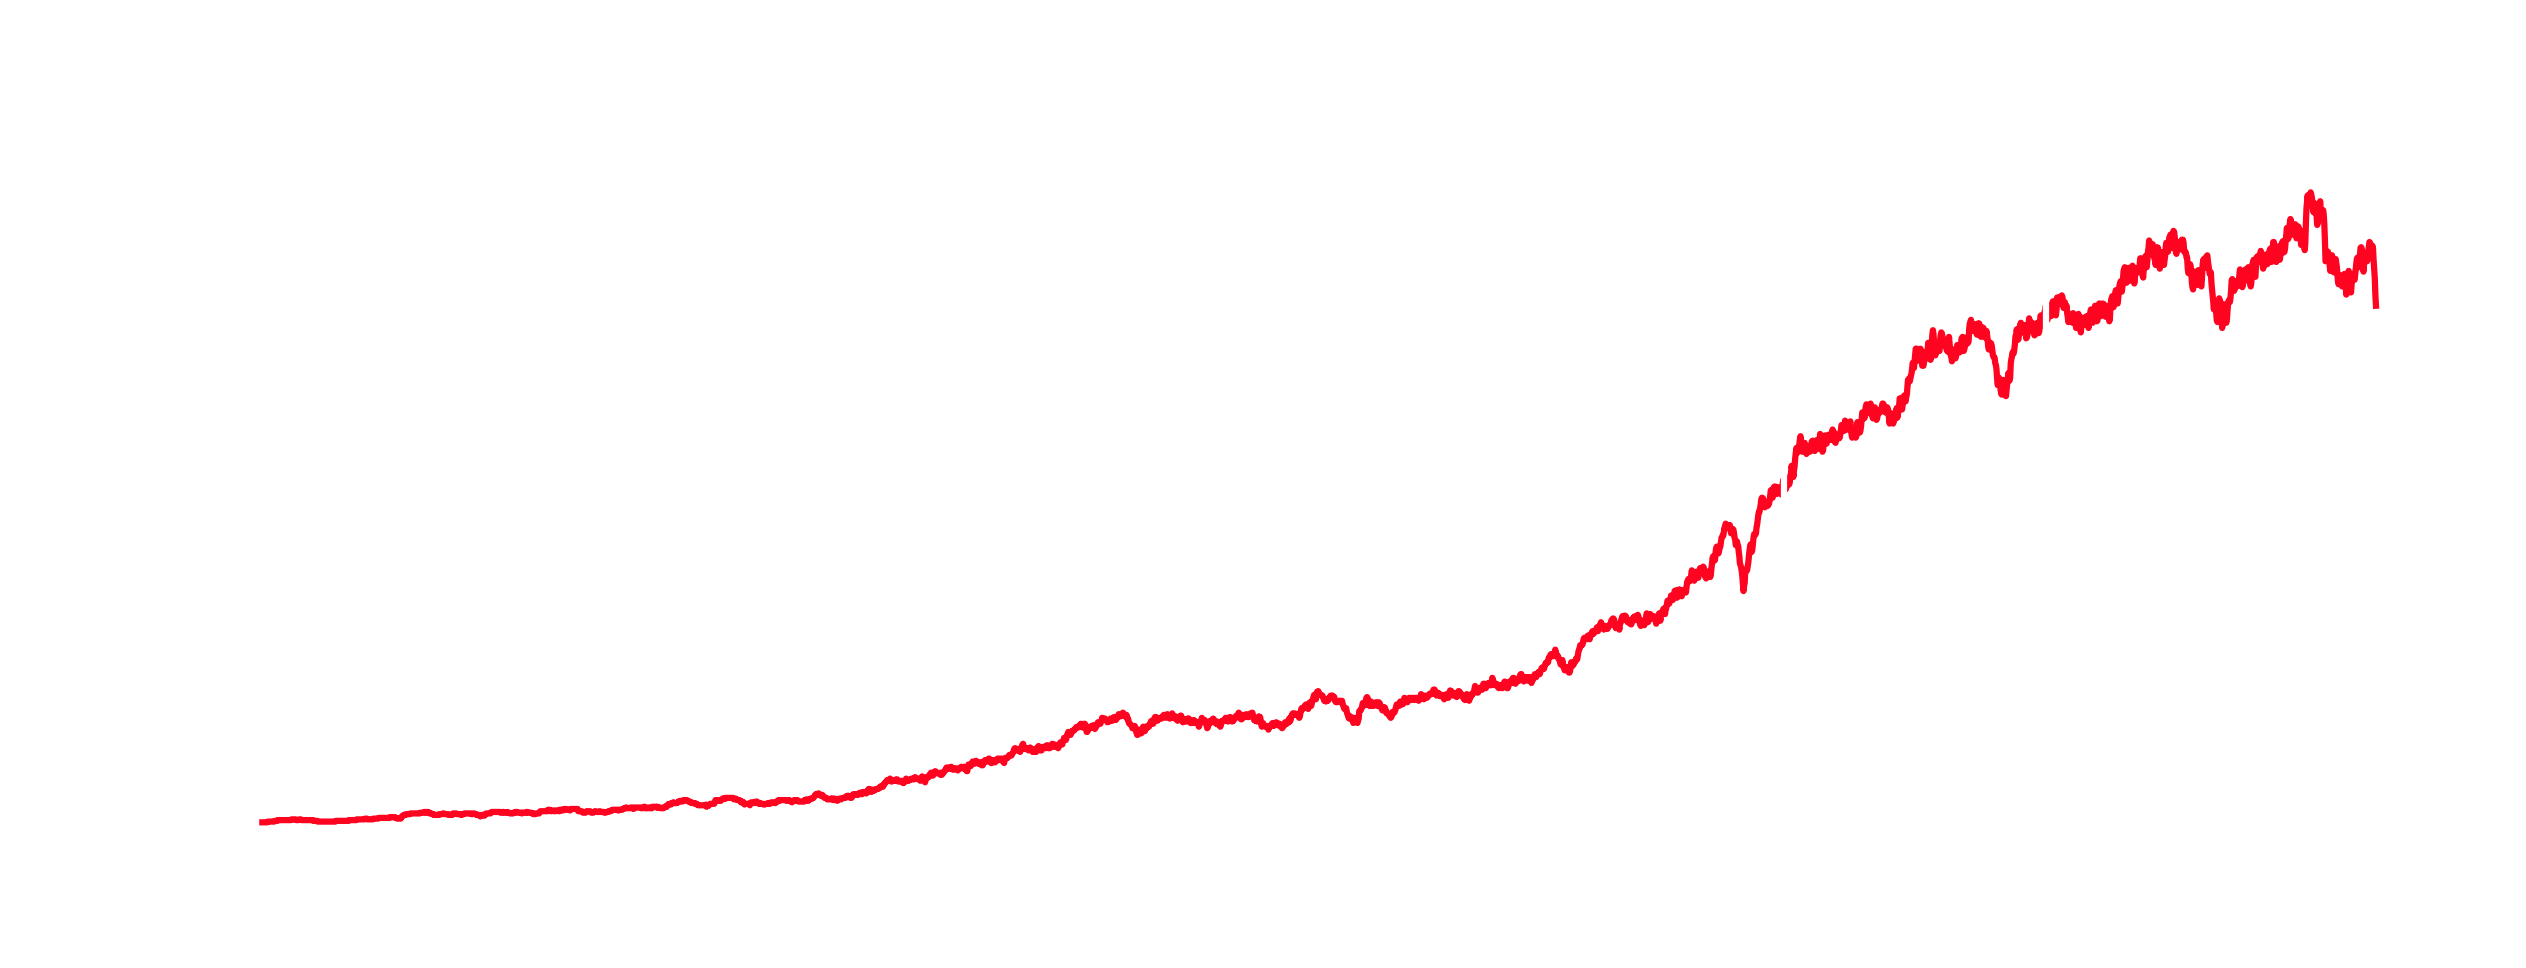

In [16]:
df_collections = pd.read_parquet('data/_local/timeseries_metrics_by_collection.parquet')

active_devs = (
    df_collections[
        (df_collections['metric_name'] == 'active_developers_over_30_day')
        & (pd.to_datetime(df_collections['sample_date']) < pd.to_datetime('2024-10-01'))
        & (df_collections['collection_name'] == 'op-rpgf3')
    ]
    .groupby('sample_date')['amount']
    .sum()
)
fig, ax = get_plot(active_devs, kind='line', color='#ff0420')
format_axis(ax)
ax.set_xlabel("")
ax.set_title("Monthly active developers, 30-day rolling average\n", loc='left', weight='bold')
ax.axvline(19000, color='white')
ax.axvline(19440, color='white')

In [17]:
maus_query = f"""
    WITH daily_unique_counts AS (
      SELECT
        time,
        event_source,
        COUNT(DISTINCT from_artifact_name) AS daily_unique_count
      FROM (
        SELECT DISTINCT
          e.time,
          e.from_artifact_name,
          e.event_source
        FROM `oso.int_events__blockchain` e
        JOIN `oso.artifacts_by_project_v1` abp
          ON e.to_artifact_id = abp.artifact_id
        JOIN `oso.projects_by_collection_v1` pbc
          ON pbc.project_id = abp.project_id
        WHERE
          e.time > '2023-12-01'
          AND pbc.collection_name = 'op-retrofunding-4'
          AND e.event_source IN ('BASE', 'OPTIMISM', 'MODE', 'METAL', 'FRAX', 'ZORA')
          AND e.event_type = 'CONTRACT_INVOCATION_SUCCESS_DAILY_COUNT'
      ) AS distinct_events
      GROUP BY time, event_source
    )

    SELECT
      time,
      event_source,
      AVG(daily_unique_count) OVER (
        PARTITION BY event_source
        ORDER BY time
        ROWS BETWEEN 29 PRECEDING AND CURRENT ROW
      ) AS rolling_30_day_unique_count
    FROM daily_unique_counts
    ORDER BY time, event_source
"""

# maus_query_result = client.query(maus_query)
# df_maus = maus_query_result.to_dataframe()
# df_maus.to_parquet('data/_local/maus.parquet')

df_maus = pd.read_parquet('data/_local/maus.parquet')
df_maus.tail(1)

,time,event_source,rolling_30_day_unique_count
1573,2024-10-25 00:00:00+00:00,ZORA,26345.833333


<Axes: xlabel='time', ylabel='rolling_30_day_unique_count'>

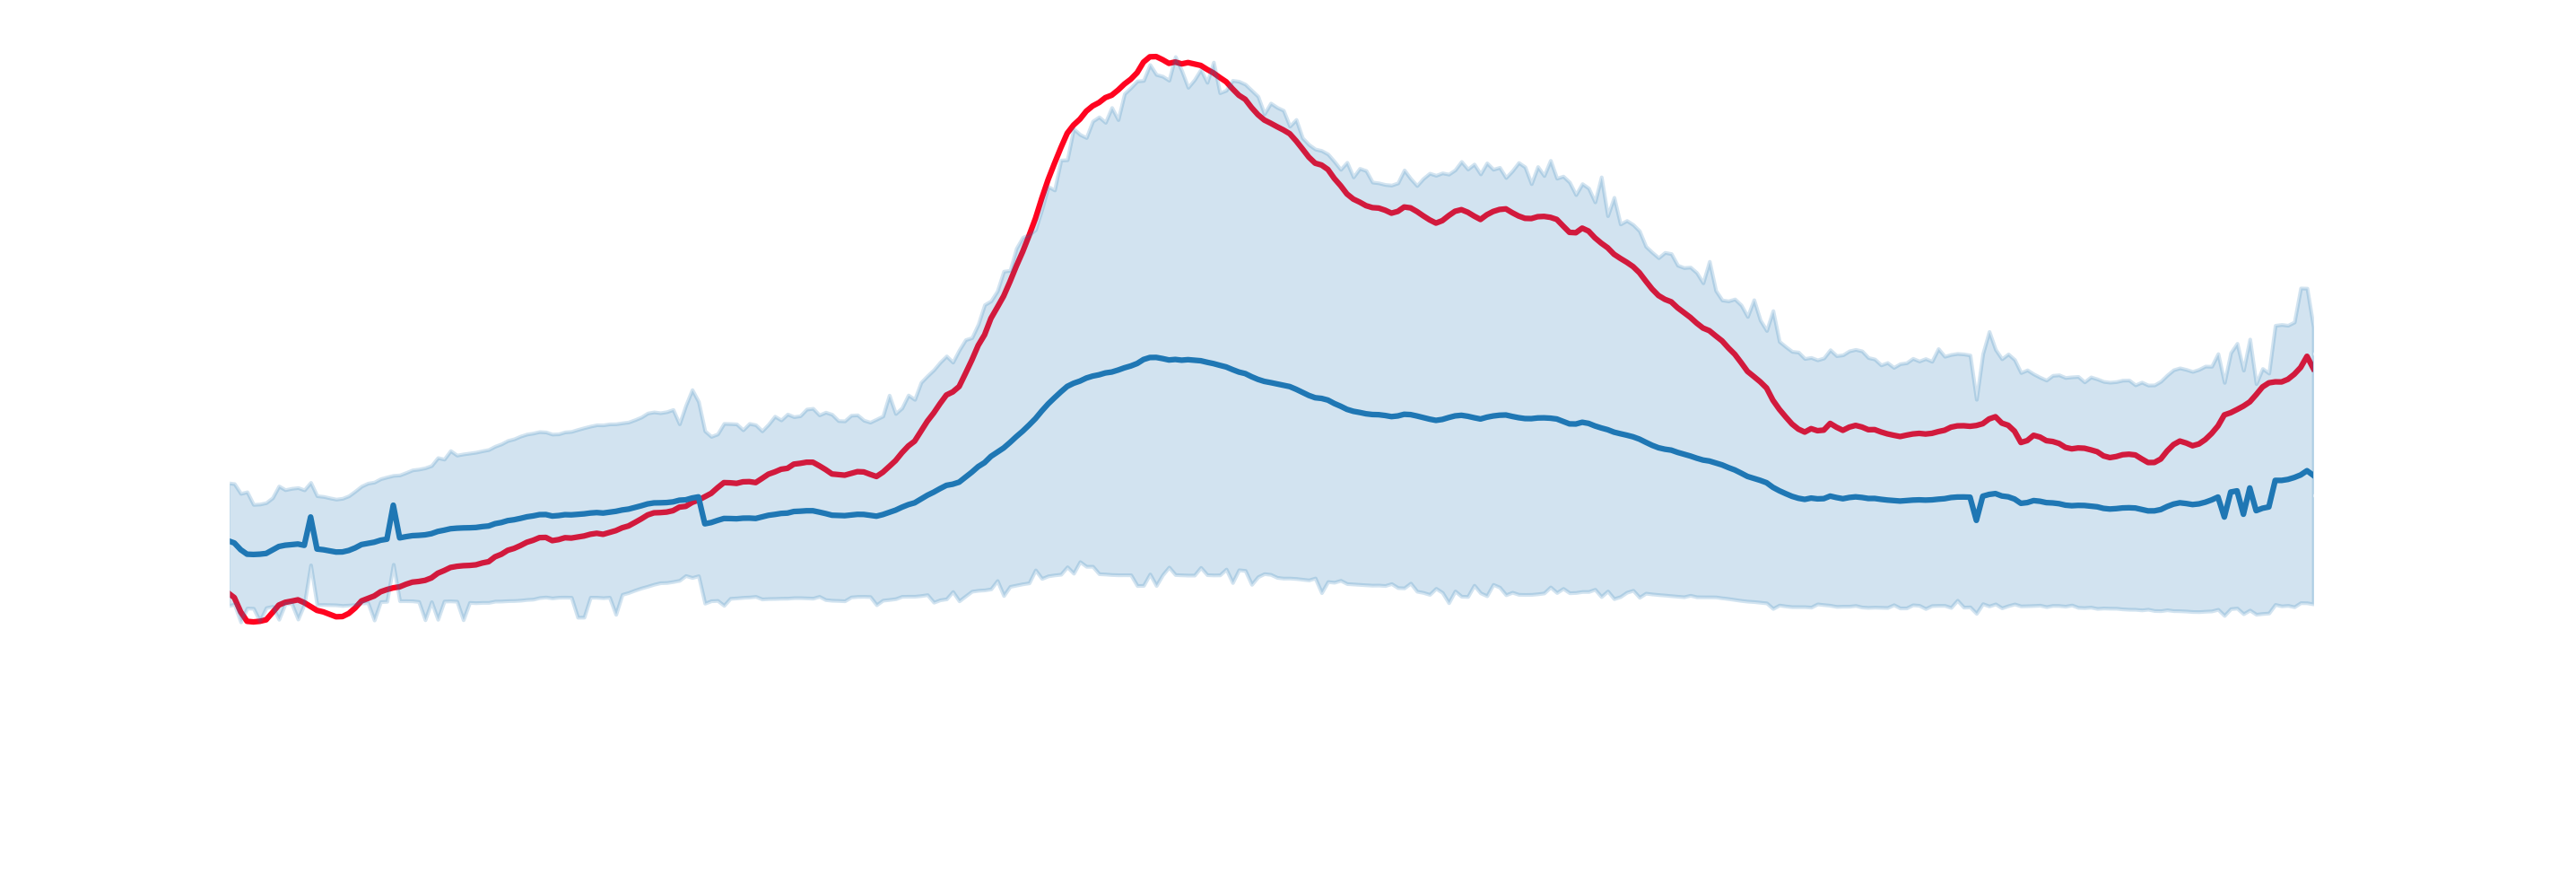

In [18]:
import seaborn as sns

fig, ax = get_plot(
    df_maus.groupby('time')['rolling_30_day_unique_count'].sum(),
    kind='line',
    color='#ff0420'
)

ax2 = ax.twinx()

sns.lineplot(
    data=df_maus,
    x='time',
    y='rolling_30_day_unique_count',
    ax=ax2
    #hue='event_source'
)

Text(0.5, 0, '')

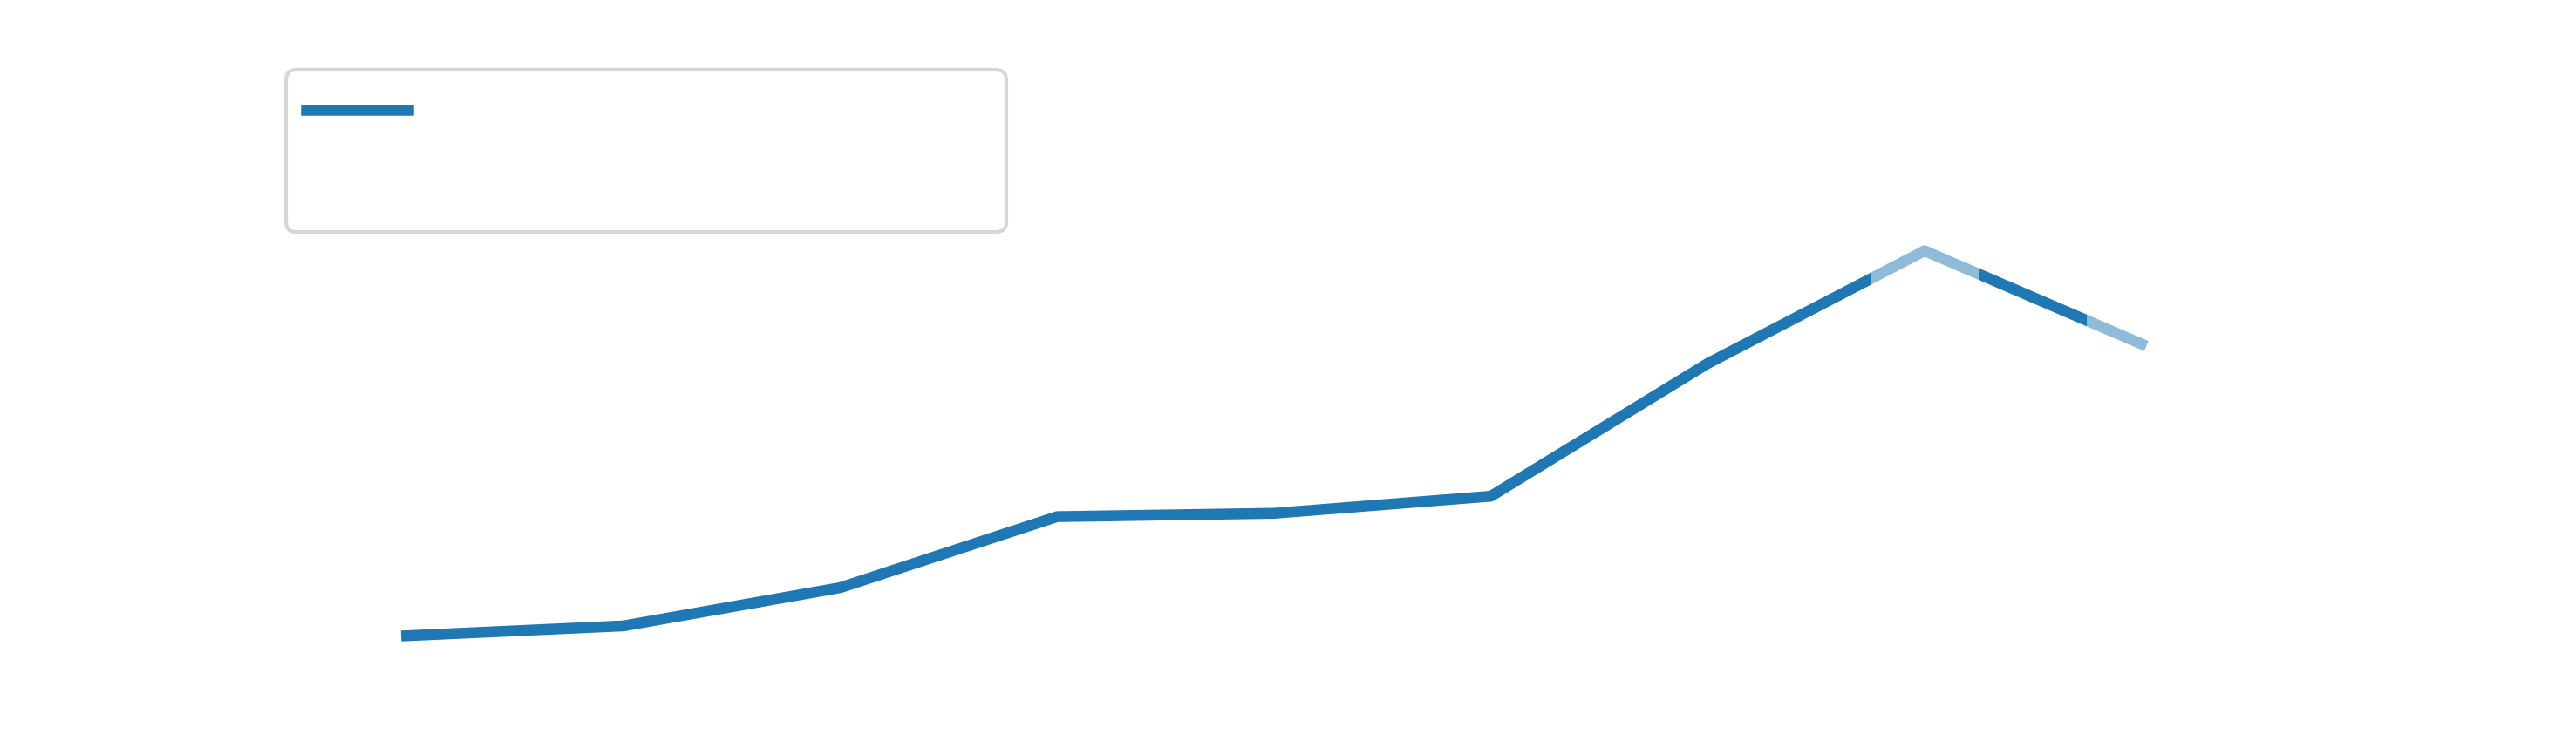

In [19]:
vc_funding = [
    (2015, 1),    # bloomberg
    (2016, 1.2),  # bloomberg
    (2017, 0.9),  # pitchbook
    (2018, 5.3),  # pitchbook
    (2019, 3.2),  # pitchbook
    (2020, 4.2),  # pitchbook
    (2021, 24.8), # pitchbook
    (2022, 29.2), # pitchbook
    (2023, 9.3),  # pitchbook
]
active_devs = [
    (2015, 1054),    # october of each year
    (2016, 1870),  
    (2017, 5035),  
    (2018, 10910),  
    (2019, 11189),  
    (2020, 12600),  
    (2021, 23584), 
    (2022, 32915), 
    (2023, 25208),  
]

df_prospective = pd.concat(
    [pd.DataFrame(active_devs, columns=['year', 'devs']).set_index('year'),
    pd.DataFrame(vc_funding, columns=['year', 'funding']).set_index('year')],
    axis=1
)

df_prospective['cum_funding'] = df_prospective['funding'].cumsum()
df_prospective.reset_index(inplace=True)
df_prospective['cost_per_dev'] = df_prospective['cum_funding'] / df_prospective['devs'] * 1000

fig, ax1 = get_plot(
    df_prospective.set_index('year')['devs'] / 1000,
    label='Active Developers',
    zorder=3,
    lw=3
)
ax2 = ax1.twinx()
ax2.bar(
    df_prospective['year'], df_prospective['cum_funding'], color='white',
    width=0.5, alpha=0.5, label='Cumulative VC Funding', zorder=1)

format_axis(ax1, ymax=50, ystep=10, ypost='K', yfmt=".0f")
ax1.set_xticks(df_prospective['year'])


lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')
ax2.spines[['right']].set_visible(True)

format_axis(ax2, ymax=100, ystep=20, ypost='B', yfmt=".0f")

ax1.set_ylabel('Active Developers\n')
ax2.set_ylabel('\nCumulative VC Funding')
ax1.set_xlabel('')
